# CSE527 Homework 3
**Due date: 23:59 on Oct 16, 2020 (Friday)**

---
In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

## Local Machine Prerequisites
---
Since we are using Google Colab, all the code is run on the server environment where lots of libraries or packages have already been installed. In case of missing 
 libraries or if you want to install them in your local machine, below are the links for installation.
* **Install Python 3.6.9**: https://www.python.org/downloads/ or use Anaconda (a Python distribution) at https://docs.continuum.io/anaconda/install/. Below are some materials and tutorials which you may find useful for learning Python if you are new to Python.
  - https://docs.python.org/3.6/tutorial/index.html
  - https://www.learnpython.org/
  - https://docs.opencv.org/4.1.2/d6/d00/tutorial_py_root.html
  - http://www.scipy-lectures.org/advanced/image_processing/index.html


* **Install Python packages**: install Python packages: `numpy`, `matplotlib`, `opencv-python` using pip, for example:
```
pip install numpy matplotlib opencv-python
``` 
	Note that when using “pip install”, make sure that the version you are using is python3. Below are some commands to check which python version it uses in you machine. You can pick one to execute:
  
```
    pip show pip
    pip --version
    pip -V
```

In case of the wrong version, use `pip3` for python3 explictly.

* **Install Jupyter Notebook**: follow the instructions at http://jupyter.org/install.html to install Jupyter Notebook and familiarize yourself  with it. *After you have installed Python and Jupyter Notebook, please open this notebook file with your Jupyter Notebook and do your homework there.*


## Using SURF in OpenCV 3.x.x
---
The default version of OpenCV in Colab is 4.1.2. But by default, it doesn't contain `SIFT` or `SURF` features anymore. Read the article below to learn more background:
- https://www.pyimagesearch.com/2015/07/16/where-did-sift-and-surf-go-in-opencv-3/

One simple way to use the OpenCV in-built function `SURF` in Colab is to switch to an older version with the `contrib` module. Below is an example of how to switch the OpenCV version:

1. Run the following command in one section in Colab, which has already been included in this assignment:
```
pip install opencv-contrib-python==3.4.2.16
```
2. Restart runtime/kernel by
```
Runtime -> Restart Runtime
```

---
If you are working on your **local machine**, you can follow the same procedure above to switch the OpenCV version. You are highly encouraged to use `virtualvenv` so that you won't mess up the packages you've already installed. 

Follow the tutorial below to create a virtual environment before you make any changes by using pip.
- https://docs.python.org/3.6/tutorial/venv.html

Then you can add the virtual environment to your notebook as a new kernel:
- https://queirozf.com/entries/jupyter-kernels-how-to-add-change-remove

Remember to run this file using your newly installed virtual kernel.

---

Check the version of OpenCV you are using now by printing `cv2.__version__`. If it shows `3.4.2`, then you should be able to use the `SURF` feature directly from OpenCV.

## Description
---
In this homework, we have two theoretical problems related to the camera model and three problems of scene recognition. For the scene recognition, we will start with very simple methods: tiny images (raw pixels), and nearest neighbor classification, and then move on to more advanced methods: bags of quantized local features and linear classifiers learned by support vector machines.

The bag of words model is a popular technique for image classification inspired by models used in natural language processing. The model ignores or downplays word arrangement (spatial information in the image) and classifies based on a histogram of the frequency of visual words. The visual word "vocabulary" is established by clustering a large corpus of local features. See Szeliski chapter 14.4.1 for more details on category recognition with quantized features. In addition, 14.3.2 discusses vocabulary creation, and 14.1 covers classification techniques.

For this homework, you will be implementing a basic bag of words model. You will classify scenes into one of 16 categories by training and testing on the 16 scene database (introduced in [Lazebnik et al.2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf), although built on top of previously published datasets). [Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf) is a great paper to read, although we will be implementing the baseline method the paper discusses (equivalent to the zero level pyramid) and not the more sophisticated spatial pyramid. For an excellent survey of pre-deep-learning feature encoding methods for the bag of words model, see [Chatfield et al, 2011](http://www.robots.ox.ac.uk/~vgg/research/encoding_eval/).

You are required to implement 2 different image representations: tiny images and bags of SURF features, and 2 different classification techniques: nearest neighbor and linear SVM. 

There are 5 problems plus a performance report in this homework with a total of 100 points. 1 bonus question with extra 30 points is provided under problem 5. The maximum points you may earn from this homework is 100 + 30 = 130 points. Be sure to read the **Submission Guidelines** below. They are important.

In [4]:
%pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 30.6MB 143kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [5]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# Replace -----/-----/-----/' with the path such that "CSE527-HW3-fall20" is your working directory
%cd '/content/gdrive/My Drive/CV/Kandari_Srinivas_112713946_HW3'

/content/gdrive/My Drive/CV/Kandari_Srinivas_112713946_HW3


In [7]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
import pickle
from sklearn import cluster, neighbors, svm
print(cv2.__version__) # verify OpenCV version

3.4.2


## Problem 1: Pinhole camera model

{15 points} The figure below shows a typical pinhole camera model. We construct a camera frame of reference centered at the focal point of the camera with the z-axis along the principal optical axis of the device. The focal length of this camera, f, is 8mm, the CCD sensor on the focal plane is 4mm wide and 3mm tall as shown. The sensor is divided into a grid of 800 pixels in the x-direction and 600pixels in the y-direction. The center of the imaging array corresponds to the point where the optical axis cuts the focal plane. The pixel coordinates are indexed from the bottom right-hand corner as shown (Attention on the axes directions).

![alt text](https://drive.google.com/uc?id=1JTRIWXjEj0v9x1vT_HuLMf_3XuZrltZ2)

- **Step 1 (2.5pt)**. Compute the matrix of intrinsic parameters which relates the coordinates of features given with respect to the camera frame to the pixel coordinates of the projection of that point on the sensor. That is give an A such that: 

![alt text](https://drive.google.com/uc?id=1k3XOPWSi0vDMNMmo12UAbwN643nglkJZ)

In [8]:
A =  np.array([[1600, 0, 400],
[0, 1600, 300],
[0, 0, 1]])
A

array([[1600,    0,  400],
       [   0, 1600,  300],
       [   0,    0,    1]])

- **Step 2 (5pt)**. Consider a wireframe cube 2 meters on the side that is initially centered and axis-aligned with the camera frame of reference; that is, initially the frame of reference of the cube and the frame of reference of the camera are initially coincident. Now consider what would happen if we first rotated the cube about the axis (3,4,-1) by 60 degrees then translated it by +10 meters along the z-axis (remember to normalize the axis to unit length).

> (i) Use a NumPy array to represent the 4x4 matrix of extrinsic parameters that correspond to the transformation from the blocks new frame of reference to the camera frame. Use the **axis/angle representation** for rotation (remember to include translation). Refer to section 2.1.4 in Szeliski for more details.

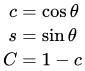

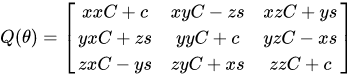

source: https://en.wikipedia.org/wiki/Rotation_matrix#Axis_and_angle

In [22]:
######## Your code here ##########

def transformation(rot_axis, rot_angle, translation):

  #calculate the 4x4 matrix using axis/angle representation
  # 1. convert the rot_axis to unit vector.
  deno = np.sqrt(np.sum(np.square(np.array(rot_axis))))
  x, y, z = [rot_axis[0]/deno, rot_axis[1]/deno, rot_axis[2]/deno]
  print(deno)
  # 2. compute c,s , C
  c=  np.cos(rot_angle * np.pi / 180)
  s=  np.sin(rot_angle * np.pi / 180)
  C= 1-c
  # 3. ext_mat = [Q t]
  ext_mat = np.array([[x*x*C + c, x*y*C - z*s, x*z*C + y*s, translation[0]], [y*x*C + z*s, y*y*C + c, y*z*C - x*s,  translation[1]], [z*x*C - y*s, z*y*C + x*s, z*z*C + c, translation[2]], [0,0,0,1]])
  return ext_mat

In [23]:
ext_mat = transformation([3,4,-1], 60, [0,0,10])
ext_mat

5.0990195135927845


array([[ 0.67307692,  0.40061079,  0.62167391,  0.        ],
       [ 0.06092768,  0.80769231, -0.58644774,  0.        ],
       [-0.73705853,  0.43260159,  0.51923077, 10.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [11]:
from scipy.spatial.transform import Rotation as R
r = transformation([3,4,-1], -60, [0,0,-10])[:-1, :-1]
r =  R.from_matrix(r)
r.as_quat()

array([-0.26915684, -0.35887579,  0.08971895,  0.8892206 ])

> (ii) Use a NumPy array to represent the 4x4 matrix of extrinsic parameters that correspond to the transformation from the blocks new frame of reference to the camera frame. Use the **quaternion representation** for rotation. Verify that you get the same result in (i) and (ii). The quaternion definition based on the axis/angle representation is given below. Refer to section 2.1.4 in Szeliski for more details.

![alt text](https://drive.google.com/uc?id=1AVOISoyBlWK_B4SuV42Xw_rZMcE35Njm)

In [12]:
######## Your code here ##########

def transformation_quaternion(rot_axis, rot_angle, translation):

  #calculate the 4x4 matrix using the quaternion representation
  # 1. convert the rot_axis to unit vector.
  x, y, z = [rot_axis[0]/sum(rot_axis), rot_axis[1]/sum(rot_axis), rot_axis[2]/sum(rot_axis)]
  # 2. compute c,s , C
  c=  np.cos(rot_angle * np.pi / 180)
  s=  np.sin(rot_angle * np.pi / 180)
  C= 1-c
  # 3. ext_mat = [Q t]
  ext_mat = np.array([[x*x*C + c, x*y*C - z*s, x*z*C + y*s, translation[0]], [y*x*C + z*s, y*y*C + c, y*z*C - x*s,  translation[1]], [z*x*C - y*s, z*y*C + x*s, z*z*C + c, translation[2]], [0,0,0,1]])
  return ext_mat

  return ext_mat_quaternion
ext_mat_quaternion = transformation_quaternion((3, 4, -1), -60, (0,0,-10))
print(ext_mat)
print(ext_mat_quaternion)

[[  0.625        0.0223291   -0.61901694   0.        ]
 [  0.31100423   0.72222222   0.37745715   0.        ]
 [  0.5356836   -0.48856826   0.51388889 -10.        ]
 [  0.           0.           0.           1.        ]]
[[  0.625        0.0223291   -0.61901694   0.        ]
 [  0.31100423   0.72222222   0.37745715   0.        ]
 [  0.5356836   -0.48856826   0.51388889 -10.        ]
 [  0.           0.           0.           1.        ]]


- **Step 3 (5pt)**. Use your answers above to compute where the vertices of the cube would appear on the image in pixel coordinates. Plot these vertices using python and connect the vertices by line segments.

In [13]:
int_mat = np.zeros((3,4))
int_mat[:, :3] = A
print(int_mat)

[[1.6e+03 0.0e+00 4.0e+02 0.0e+00]
 [0.0e+00 1.6e+03 3.0e+02 0.0e+00]
 [0.0e+00 0.0e+00 1.0e+00 0.0e+00]]


[[1.6e+03 0.0e+00 4.0e+02 0.0e+00]
 [0.0e+00 1.6e+03 3.0e+02 0.0e+00]
 [0.0e+00 0.0e+00 1.0e+00 0.0e+00]]


[[12468.035682489233, 2308.577184895938],
 [728.8807101306954, 450.9849901172324],
 [-488.82020203405966, -2561.181673689011],
 [-1766.2030702025775, 3529.928844564291],
 [-1833.8515338162372, 3630.7964533872178],
 [-467.4975846445225, -2492.5425023803364],
 [732.7985431822916, 452.78361790644254],
 [13646.705409214324, 2504.752368986811]]

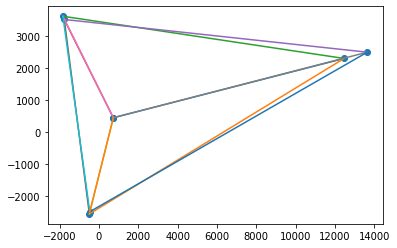

In [25]:
######## Your code here ##########

def get_pixel_coordinates(vertices, int_mat, ext_mat):

  # calculate where each vertex of the cube maps to, in pixel coordinates.
  vertices_pixel = []
  for v in vertices:
    p = int_mat.dot(ext_mat.dot(np.array(v).T))
    pixel = [0,0]
    pixel[0] = p[0] / p[2]
    pixel[1] = p[1] / p[2]
    vertices_pixel.append(pixel)

  return vertices_pixel

int_mat = np.zeros((3,4))
int_mat[:, :3] = A
print(int_mat)
pixels = get_pixel_coordinates(np.array([[1000,1000,1000,1],[-1000,1000,1000,1],[1000,1000,-1000,1],[-1000,1000,-1000,1],[1000,-1000,1000,1],[-1000,-1000,1000,1],[1000,-1000,-1000,1],[-1000,-1000,-1000,1]]), int_mat, ext_mat)

def draw_cube(vertices_pixel):
  vertices_pixel = np.array(vertices_pixel)
  plt.plot([vertices_pixel[0][0], vertices_pixel[1][0]],[vertices_pixel[0][1], vertices_pixel[1][1]])
  plt.plot([vertices_pixel[0][0], vertices_pixel[2][0]],[vertices_pixel[0][1], vertices_pixel[2][1]])
  plt.plot([vertices_pixel[0][0], vertices_pixel[4][0]],[vertices_pixel[0][1], vertices_pixel[4][1]])
  plt.plot([vertices_pixel[3][0], vertices_pixel[1][0]],[vertices_pixel[3][1], vertices_pixel[1][1]])
  plt.plot([vertices_pixel[3][0], vertices_pixel[7][0]],[vertices_pixel[3][1], vertices_pixel[7][1]])
  plt.plot([vertices_pixel[3][0], vertices_pixel[2][0]],[vertices_pixel[3][1], vertices_pixel[2][1]])
  
  plt.plot([vertices_pixel[6][0], vertices_pixel[4][0]],[vertices_pixel[6][1], vertices_pixel[4][1]])
  plt.plot([vertices_pixel[6][0], vertices_pixel[7][0]],[vertices_pixel[6][1], vertices_pixel[7][1]])
  plt.plot([vertices_pixel[6][0], vertices_pixel[2][0]],[vertices_pixel[6][1], vertices_pixel[2][1]])
  plt.plot([vertices_pixel[5][0], vertices_pixel[4][0]],[vertices_pixel[5][1], vertices_pixel[4][1]])
  plt.plot([vertices_pixel[5][0], vertices_pixel[7][0]],[vertices_pixel[5][1], vertices_pixel[7][1]])
  plt.plot([vertices_pixel[5][0], vertices_pixel[1][0]],[vertices_pixel[5][1], vertices_pixel[1][1]])
  
  plt.scatter(vertices_pixel[:,0], vertices_pixel[:,1])
draw_cube(pixels)
pixels
  # draw cube using matplotlib.pyplot
  # use imshow to show your output

- **Step 4 (2.5pt)**. Find out where the points at infinity corresponding to the x, y, and z directions of the cube's new frame of reference would project onto the image (**hint:** extend parallel lines)

In [ ]:
######## Your code here ##########

def get_vanishing_points(vertices_pixel):

  # calculate the vanishing points by extending parallel lines in x,y,z directions of cubes new frame of reference

  return vanishing_points

print("vanishing point in x:", )
print("vanishing point in y:", )
print("vanishing point in z:", )

vanishing point in x:
vanishing point in y:
vanishing point in z:


## Problem 2: Camera calibration

{15 points} A fixed camera views a table of variable height, illuminated by a projector that projects a cross-pattern onto the table. The system is to be calibrated by adjusting the height of the table to heights of precisely 50mm, 100mm, and 200mm. At each of these heights, the center of the cross-pattern is measured in images at the following positions (in pixels): (u, v) = (100, 250), (140, 340), and (200, 450), respectively. Notice that the projected ray of light has the same algebraic representation as to the ray imaging to a camera. To simplify matters, choose a convenient world frame.

- **Step 1 (2.5pt)**. What are the (i) perspective projection camera model (i.e. the model that contains all the perspective projection parameters) and the (ii) projective camera model (i.e. the model that relates directly the point in 3D with its final projection in the image), specialized for this particular problem configuration? Give your answer as equations using homogeneous coordinates that show how a scene point is mapped to an image point.

i. Perspective : [s* u, s*v, s] = [[p11, p12], [p21, p22], [p31, p32]] * [x 1]


ii. Projective: [s* u, s*v, s] = [[p11, p12], [p21, p22], [p31, p32]] * [[r11, tx], [r21, 0], [r31, 0]] * [x 1] (No rotation and translation in y and z )


- **Step 2 (2.5pt)**. In the projective camera model you defined in the previous step, how many degrees of freedom are there to calibrate this system?

7 Degrees of freedom, 5 from intrinsic(persecptive) and 2 from extrinsic

- **Step 3 (5pt)**. Compute all of the calibration parameters for this problem (use your projective camera model from the previous steps). (**hint**: Convert the problem to the form Ax=b where x is a column vector of all the unknowns, and use NumPy arrays to solve for the linear least squares solution. Use the pseudo-inverse.)

In [48]:
######## Your code here ##########

def get_projective(heights, pixel_coordinates):

  # solving the system using pseudo-inverse, return the projective matrix
  A = []
  B = []
  for i in range(len(heights)):
    x = heights[i]
    u = pixel_coordinates[i][0]
    v = pixel_coordinates[i][1]
    A.append([x, 1,0,0, -u*x])  # No need to add coeff of p32 as we can divide the entire matrix by p32 and it would just scale the output, essentially 5 parameters
    B.append(u)
    A.append([0, 0,x, 1, -v*x])
    B.append(v)
  
  print(np.array(A), np.array(B))
  A_ = np.linalg.pinv(np.array(A))
  X = A_.dot(np.array(B))
  X = np.append(X, 1)
  projective_mat = np.reshape(X, (3,2))
  return projective_mat

# print(projective_mat)

projective_mat = get_projective([50,100, 200], [[100,250], [140,340], [200,450]])

[[    50      1      0      0  -5000]
 [     0      0     50      1 -12500]
 [   100      1      0      0 -14000]
 [     0      0    100      1 -34000]
 [   200      1      0      0 -40000]
 [     0      0    200      1 -90000]] [100 250 140 340 200 450]


- **Step 4 (5pt)**. Recover the height of the table when the cross is measured in three new images at the following pixel coordinates. Show how you obtained your answers as well.

> (i) (130, 310)

> (ii) (170, 380)

> (iii) (190, 300)

In [57]:
projective_mat

array([[1.74616800e+00, 3.32618026e+01],
       [3.70110362e+00, 1.23819742e+02],
       [4.59227468e-03, 1.00000000e+00]])

In [67]:
######## Your code here ##########

def get_height(projective_mat, pixel_coordinates):

  # calculate height which corresponds to each pixel coordinate
  height = (projective_mat[0,1] - pixel_coordinates[0]) / (projective_mat[2,0] * pixel_coordinates[0] - projective_mat[0,0])
  return height

height1  = get_height(projective_mat, np.array([130,310,1]))
height2  = get_height(projective_mat, np.array([170,380,1]))
height3  = get_height(projective_mat, np.array([190, 300,1]))
print(height1, height2, height3)

print("height corresponding to (130, 310):", height1)
print("height corresponding to (170, 380):", height2)
print("height corresponding to (190, 300):", height3)

84.18076081726372 141.62697656676013 179.4090813387853
height corresponding to (130, 310): 84.18076081726372
height corresponding to (170, 380): 141.62697656676013
height corresponding to (190, 300): 179.4090813387853


## Scene Recognition

### Dataset and Starter Code
---
Upload [dataset.pkl](https://drive.google.com/file/d/1m2k-ytHOV3OB1nv1eGZbZkNPfwNILqN6/view?usp=sharing) into your working folder for this homework.

**Do not upload** the pkl file when submitting on blackboard due to the size limit.

The dataset contains 16 categories. And for each category, 150 training images and 50 test images are provided (i.e. 2400 training examples, 400 labeled test cases, and 400 unlabeled test cases). In a real research paper, one would be expected to test performance on random splits of the data into training and test sets, but we do not do this to ease debugging. To make your task a little easier, below we provide some starter code that randomly guesses the category of every test image and achieves about 6.25% accuracy (1 out of 16 guesses is correct).


In [26]:
!ls

CSE527_HW3_fall20.ipynb  cvpr06b.pdf  download.png  sample.txt
cvpr05.pdf		 dataset.pkl  iccv07.pdf


Class names:  {0: 'Flower', 1: 'Mountain', 2: 'Kitchen', 3: 'Office', 4: 'Store', 5: 'Street', 6: 'Forest', 7: 'InsideCity', 8: 'OpenCountry', 9: 'LivingRoom', 10: 'Coast', 11: 'Bedroom', 12: 'Industrial', 13: 'TallBuilding', 14: 'Highway', 15: 'Suburb'}
Loaded training images: 2400, labels: 2400
Loaded test images: 400, labels: 400
Loaded unlabeled test images: 400


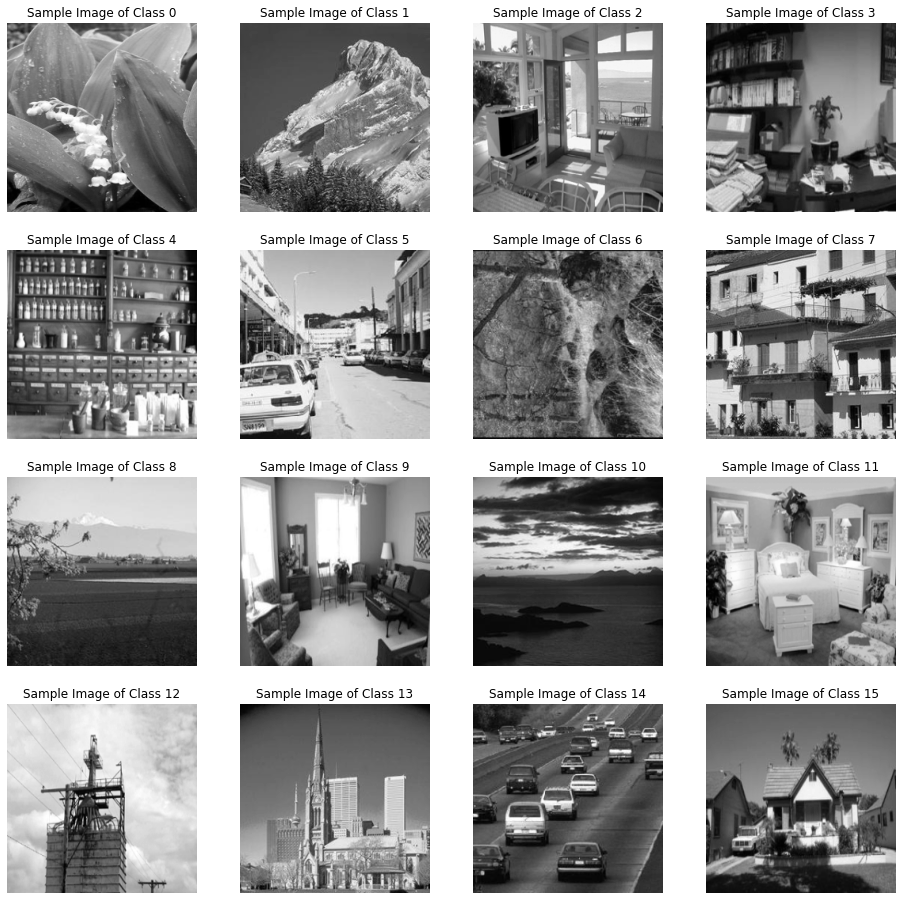

In [27]:
# Load intermediate image data from disk
with open('dataset.pkl', 'rb') as file:
    train_data = pickle.load(file)
    train_label = pickle.load(file)
    test_data = pickle.load(file)
    test_label = pickle.load(file)
    class_names = pickle.load(file)
    unlabeled_test_data = pickle.load(file)

print("Class names: ", class_names)
# Verify number of training samples (should be 2400)
print(f"Loaded training images: {len(train_data)}, labels: {len(train_label)}") 
# Verify number of testing samples (should be 400)
print(f"Loaded test images: {len(test_data)}, labels: {len(test_label)}")   
# Verify number of testing samples (should be 400)
print(f"Loaded unlabeled test images: {len(unlabeled_test_data)}")  

# plt.imshow(train_data[1], cmap='gray') # Verify image
img_new_size = (240, 240)

train_data = [cv2.resize(i, img_new_size) for i in train_data]
train_data = np.stack(train_data)
train_label = np.array(train_label)

test_data = [cv2.resize(i, img_new_size) for i in test_data]
test_data = np.stack(test_data)
test_label = np.array(test_label)

unlabeled_test_data = [cv2.resize(i, img_new_size) for i in unlabeled_test_data]
unlabeled_test_data = np.stack(unlabeled_test_data)

# Verify images
plt.figure(figsize=(16, 16))
for j in range(4):
    for i in range(4):
        img_cls = i * 4 + j
        plt.subplot(4, 4, img_cls + 1)
        plt.title(f'Sample Image of Class {img_cls}')
        plt.imshow(train_data[150 * img_cls], cmap='gray')
        plt.axis("off")
plt.show()

In [68]:
n_train = len(train_label)
n_test = len(test_label)

# feature extraction
def extract_feat(raw_data):
    feat_dim = 1000
    feat = np.zeros((len(raw_data), feat_dim), dtype=np.float32)
    for i in np.arange(feat.shape[0]):
        feat[i] = np.reshape(raw_data[i], (raw_data[i].size))[:feat_dim] # dummy implemtation
    print("Feature length: ",len(feat))
    
    return feat

train_feat = extract_feat(train_data)
test_feat = extract_feat(test_data)

# model training: take feature and label, return model
def train(X, Y):
    return 0 # dummy implementation

# prediction: take feature and model, return label
def predict(model, x):
    return np.random.randint(16) # dummy implementation

# evaluation
predictions = [-1]*len(test_feat)
for i in np.arange(n_test):
    predictions[i] = predict(None, test_feat[i])
    
accuracy = sum(np.array(predictions) == test_label) / float(n_test)

print("The accuracy of my dummy model is {:.2f}%".format(accuracy*100))

Feature length:  2400
Feature length:  400
The accuracy of my dummy model is 8.00%


## Problem 3: Tiny Image Representation + Nearest Neighbor Classifier
{15 points} You will start by implementing the tiny image representation and the nearest neighbor classifier. They are easy to understand, easy to implement and run very fast for our experimental setup.

The "tiny image" feature is one of the simplest possible image representations. One simply resizes each image to a small, fixed resolution. You are required to **resize the image** to `16x16` and **reshape** it to a vector of length `256`. It works slightly better if the tiny image is made to have zero mean and unit length (normalization). This is not a particularly good representation, because it discards all of the high-frequency image content and is not especially invariant to spatial or brightness shifts. We are using tiny images simply as a baseline.

The nearest neighbor classifier is equally simple to understand. When tasked with classifying a test feature into a particular category, one simply finds the "nearest" training example (L2 distance is a sufficient metric) and assigns the label of that nearest training example to the test example. The nearest neighbor classifier has many desirable features — it requires no training, it can learn arbitrarily complex decision boundaries, and it trivially supports multiclass problems. It is quite vulnerable to training noise, though, which can be alleviated by voting based on the K nearest neighbors (but you are not required to do so). Nearest neighbor classifiers also suffer as the feature dimensionality increases, because the classifier has no mechanism to learn which dimensions are irrelevant for the decision.

Report your classification accuracy on the test sets and time consumption.

**Hints**:
- Use [cv2.resize()](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#resize) to resize the images;
- Use [NearestNeighbors in Sklearn](http://scikit-learn.org/stable/modules/neighbors.html) as your nearest neighbor classifier.

In [29]:
cv2.resize(train_data[i], (16,16)).size
# plt.imshow(train_data[i])

256

In [69]:
img_tiny = (16, 16)

start = time.time()

##########--WRITE YOUR CODE HERE--##########
# extract features
def extract_feat(raw_data):
  data = np.zeros([raw_data.shape[0], 256])
  for i in range(raw_data.shape[0]):
    temp = np.reshape(cv2.resize(raw_data[i], (16,16)), 256)
    data[i] = (temp - np.mean(temp)) / np.std(temp)
    # data[i] = cv2.resize(raw_data[i], (16,16))
  print(data.shape)
  return data

train_tiny =extract_feat(train_data)
test_tiny = extract_feat(test_data)

# train model
# def KNN():
#   def fit(X, y):
#     self.X = X
#     self.y = y
#   def predict(data):
#     for i in range(data.shape[0]):
#       dists = self.X - data[i]

model = neighbors.NearestNeighbors(1)
model.fit(train_tiny, train_label)
  
# predict labels
pred1 = [train_label[i] for i in model.kneighbors(test_tiny, return_distance=False)]

# calculate accuracy
accuracy = 0 
for i in range(len(pred1)):
  if(pred1[i] == test_label[i]):
    accuracy +=1
accuracy /= len(pred1)
##########-------END OF CODE-------##########

end = time.time()

time_p1 = end - start
accuracy_p1 = accuracy


print(f"The accuracy of Tiny Image Representation + Nearest Neighbor Classifier model is {accuracy_p1 * 100:.2f}%")
print(f"Time consumpted is {time_p1:.2f} seconds")
# pred1, label1 = # train_and_test(...


(2400, 256)
(400, 256)
The accuracy of Tiny Image Representation + Nearest Neighbor Classifier model is 23.00%
Time consumpted is 0.81 seconds


In [31]:
test_data.shape

(400, 240, 240)

## Problem 4: Bag of SURF Representation + Nearest Neighbor Classifer
{30 points}
After you have implemented a baseline scene recognition pipeline it is time to move on to a more sophisticated image representation — bags of quantized SURF features. Before we can represent our training and testing images as a bag of feature histograms, we first need to establish a vocabulary of visual words. We will form this vocabulary by sampling many local features from our training set (10's or 100's of thousands) and then cluster them with k-means. The number of k-means clusters is the size of our vocabulary and the size of our features. For example, you might start by clustering many SURF descriptors into k=50 clusters. This partitions the continuous, 64-dimensional SURF feature space into 50 regions. For any new SURF feature we observe, we can figure out which region it belongs to as long as we save the centroids of our original clusters. Those centroids are our visual word vocabulary. Because it can be slow to sample and cluster many local features, the starter code saves the cluster centroids and avoids recomputing them on future runs.

Now we are ready to represent our training and testing images as histograms of visual words. For each image, we will densely sample many SURF descriptors. Instead of storing hundreds of SURF descriptors, we simply count how many SURF descriptors fall into each cluster in our visual word vocabulary. This is done by finding the nearest neighbor k-means centroid for every SURF feature. Thus, if we have a vocabulary of 50 visual words, and we detect 220 distinct SURF features in an image, our bag of SURF representation will be a histogram of 50 dimensions where each bin counts how many times a SURF descriptor was assigned to that cluster. The total of all the bin-counts is 220. The histogram should be normalized so that image size does not dramatically change the bag of features magnitude.

After you obtain the Bag of SURF feature representation of the images, you have to train a KNN classifier in the Bag of SURF feature space and report your test set accuracy and time consumption.

**Note**: 
- Instead of using SURF to detect invariant keypoints, you are recommended to densely sample keypoints in a grid with certain step size (sampling density) and scale.
- There are many design decisions and free parameters for the bag of SURF representation (number of clusters, sampling density, sampling scales, SURF parameters, etc.) so accuracy might vary.
- Indicate clearly the parameters you use along with the prediction accuracy on test set and time consumption.
- Training the vocabulary might be time-consuming. You can use a smaller vocabulary for sanity check first.

**Hints**:
- Use [KMeans in Sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to do clustering and find the nearest cluster centroid for each SURF feature;
- Use `cv2.xfeatures2d.SURF_create()` to create a SURF object;
- Use `surf.compute()` to compute SURF descriptors given densely sampled keypoints ([cv2.Keypoint](https://docs.opencv.org/3.0-beta/modules/core/doc/basic_structures.html?highlight=keypoint#keypoint)).
- Be mindful of RAM usage. Try to make the code more memory efficient, otherwise it could easily exceed RAM limits in Colab, at which point your session will crash.
- If your RAM is going to run out of space, use [gc.collect()](https://docs.python.org/3/library/gc.html) for the garbage collector to collect unused objects in  memory to free some space.
- Store data or features as NumPy arrays instead of lists. Computation on NumPy arrays is much more efficient than lists.

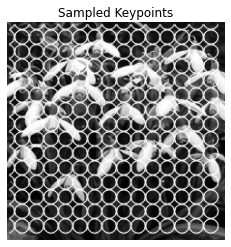

Processing training set
Extract SURF data
Train BoW
Assemble features
Processing test set
Extract SURF data
Predict BoW label
Assemble features
[ 5  0  4  0 15  4  0  0  9  7  2 15  3  0  0  0  4  0 15  2  0  0  0  0
  0  8  1  1 15  1  4  4  8  1  0  4  1  8  1 14 15  5  1  0  4  2  1 15
  5  1 12 11 11  9  9  2  2  3 11  4  7  9 11  2 11  2 11  2  7  2  2 15
  3  9  2 11  3  0  2  3  3  2  2  3  3  3  3  3  3  9  3  1  3  2  4  2
  2  2 11  2  5  2  2  4  5  4  5  4  2  5  4  0  0 15  0  0  5  7 12  1
 11  0  4  9  0  4  5  1  5  0 12  5 14  5  5  1  9  4  0  5  5  3  5  4
  0 12  2  4 12  5  6  6  6  6  6  6  6  6  6  6  0  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  7  7  4  7  1  7  4  7  4  5  7  0  5  2  7 10  2
  5  4  0  0  2  2  5  7  5  0  8 10  8 12 10  1  1  8  5  6  8  4  0  8
  8  1 14  5 13 15  8 15  8  4  9  4  7 11 15  2  9  2 12  2  9  9  4  2
  0  3  4  2  0  9 14  3  2  3  6 10  8  0 14 14 14  0  0 14 13 14 14 10
 13 10 10  5 14  1  2 10  7  4  0  3  2  4 15 11 12  

In [70]:
# Write your codes here
np.random.seed(42)

start = time.time()
##########--WRITE YOUR CODE HERE--##########
# The following steps are just for your reference
# You can write in your own way
#
# # densely sample keypoints
# def sample_kp(shape, stride, size):
def sample_kp(shape, stride, size):
  kps = []
  for i in range(0, shape[0], stride):
    for j in range(0, shape[1], stride):
      kps.append(cv2.KeyPoint(i, j, size))
      # cv2.KeyPoint()

  return kps
SURF = cv2.xfeatures2d.SURF_create()
# extract vocabulary of SURF features

k = []
def extract_vocabulary(raw_data, key_point):
  vocabulary = cluster.KMeans(50)
  Ds = np.array([0] *64)
  for img in raw_data:
    _, desc = SURF.compute(img, key_point)
    Ds = np.vstack((Ds, desc))
  vocabulary.fit(Ds[1:])
  return vocabulary   

# extract Bag of SURF Representation of images
def extract_feat(raw_data, vocabulary, key_point): 
  feats = np.zeros((raw_data.shape[0], 50))
  for i in range(raw_data.shape[0]):
    # bag = [0] *50
    _, desc = SURF.compute(raw_data[i], key_point)
    for d in desc:
      feats[i][vocabulary.predict(d.reshape(1,-1))] += 1
    # feats.append(bag)
  return feats


# generate keypoints
skp = sample_kp((train_data.shape[1], train_data.shape[2]), 16, 16)
##########-------END OF CODE-------##########

# draw keypoints
# add more visualization if you want to
draw_kp = cv2.drawKeypoints(train_data[15], skp, np.array([]), (255,255,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure()
plt.imshow(draw_kp)
plt.title('Sampled Keypoints')
plt.axis("off")
plt.show()

##########--WRITE YOUR CODE HERE--##########
# extract training data and train vocabulary

print("Processing training set")
print("Extract SURF data")
# train_surf_data = 
print("Train BoW")
vocabulary = extract_vocabulary(train_data, skp)
print("Assemble features")
bow_train_feat = extract_feat(train_data, vocabulary, skp)


print("Processing test set")
# prepare test data
print("Extract SURF data")
# test_surf_data = 
print("Predict BoW label")
# test_surf_label = extract_vocabulary(test_data, skp)
print("Assemble features")
bow_test_feat = extract_feat(test_data, vocabulary, skp)

##########-------END OF CODE-------##########

# this block should generate 
# train_feat and test_feat corresponding to bow_train_feat and bow_test_feat
mid = time.time()
##########--WRITE YOUR CODE HERE--##########
# train model
model = neighbors.KNeighborsClassifier()
model.fit(bow_train_feat, train_label)

pred2 = model.predict(bow_test_feat)
accuracy = 0 
for i in range(len(pred2)):
  if(pred2[i] == test_label[i]):
    accuracy +=1
accuracy /= len(pred2)
# predict labels
# calculate accuracy
# accuracy = 
##########-------END OF CODE-------##########
print(pred2, accuracy)
end = time.time()

time_p2 = end - start
accuracy_p2 = accuracy


print(f"The accuracy of Bag of SURF Representation + Nearest Neighbor Classifier model is {accuracy_p2 * 100:.2f}%")
print(f"Time consumpted is {time_p2:.2f} seconds")


In [ ]:
gc.collect()

34758

## Problem 5.a: Bag of SURF Representation + one-vs-all SVMs
{10 points}
The last task is to train one-vs-all linear SVMs to operate in the bag of SURF feature space. Linear classifiers are one of the simplest possible learning models. The feature space is partitioned by a learned hyperplane and test cases are categorized based on which side of that hyperplane they fall on. Despite this model being far less expressive than the nearest neighbor classifier, it will often perform better.

You do not have to implement the support vector machine. However, linear classifiers are inherently binary and we have a 16-way classification problem (the library has handled it for you). To decide which of 16 categories a test case belongs to, you will train 16 binary, one-vs-all SVMs. One-vs-all means that each classifier will be trained to recognize 'forest' vs 'non-forest', 'kitchen' vs 'non-kitchen', etc. All 16 classifiers will be evaluated on each test case and the classifier which is most confidently positive "wins". E.g. if the 'kitchen' classifier returns a score of -0.2 (where 0 is on the decision boundary), and the 'forest' classifier returns a score of -0.3, and all of the other classifiers are even more negative, the test case would be classified as a kitchen even though none of the classifiers put the test case on the positive side of the decision boundary. When learning an SVM, you have a free parameter $\lambda$ (lambda) which controls how strongly regularized the model is. Your accuracy will be very sensitive to $\lambda$, so be sure to try many values.

Indicate clearly the parameters you use along with the prediction accuracy on test set and time consumption.

**Hints**:
- Use SVM in
  [Sklearn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
  (recommended) or
  [OpenCV](https://docs.opencv.org/3.0-alpha/modules/ml/doc/support_vector_machines.html)
  to do training and prediction.

In [71]:
# reuse the features in the last block
start2 = time.time()

##########--WRITE YOUR CODE HERE--##########
model_svm = svm.SVC(C= 1) #rbf kernel, regularization param 1 gives best on test set
model_svm.fit(bow_train_feat, train_label)
pred3 = model_svm.predict(bow_test_feat)
accuracy = 0
for i in range(len(pred3)):
  if(pred3[i] == test_label[i]):
    accuracy +=1
accuracy /= len(pred3) 
# accuracy

 
##########-------END OF CODE-------##########
end = time.time()

time_p3 = end - start2 + mid - start
accuracy_p3 = accuracy

accuracy = np.mean(np.array(pred3) == test_label)
print(f"The accuracy of Bag of SURF Representation + one-vs-all SVMs model is {accuracy_p3 * 100:.2f}%")
print(f"Time consumpted is {time_p3:.2f} seconds")


The accuracy of Bag of SURF Representation + one-vs-all SVMs model is 49.75%
Time consumpted is 1349.70 seconds


In [34]:
gc.collect()

34471

## Problem 5.b: Build your own model

**Bonus {30 points}**: For this question, you need to build your own model and generate predictions for the `unlabeled_test_data`. The prediction file(**Surname_Givenname_SBUID_Pred.txt**) should follow the exact format as given in the **sample.txt** file. Please write your code below and give a detailed introduction of what you did and why you did so (10 points).

The other 20 points will be graded on the accuracy of your model. You can get 5 points as long as you submit the file in the correct format. Students whose accuracy ranks top 50% in this homework will get 10 points. 15 points will be given to students whose accuracy ranks top 10. And Top 3 can get full 20 points.

After the grading, some representative models will be made available to all the students anonymously.


In [72]:
def to_rgb(img):
    img = cv2.resize(img, (240,240), interpolation = cv2.INTER_AREA) 
    img_rgb = np.asarray(np.dstack((img, img, img)), dtype=np.uint8)
    return img_rgb
def convert_images(data):
  data_rgb = np.zeros((data.shape[0], 240, 240, 3))
  for i in range(data.shape[0]):
    data_rgb[i] = to_rgb(data[i])
  return data_rgb

In [73]:
# train_data_rgb = convert_images(train_data)
# test_data_rgb = convert_images(test_data)
# subm_data_rgb = convert_images(unlabeled_test_data)

In [74]:
# Write your code here
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel
from tensorflow.keras import datasets, layers, models

# Using VGG16 Model with weights initialized to Imagenet dataset training

ptm = PretrainedModel(
    input_shape=(240, 240, 3),
    weights='imagenet',
    include_top=False)
# # Freezing weights 
ptm.trainable = False
x = layers.Flatten()(ptm.output)
x = layers.Dense(36, activation='relu')(x)
x = layers.Dense(16, activation='softmax')(x)
trans_model = models.Model(inputs = ptm.input, outputs = x)
trans_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)      

In [75]:
# trans_model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# trans_history = trans_model.fit(train_data_rgb, train_label, epochs=40, 
#                     validation_data=(test_data_rgb, test_label))


In [76]:
# preds = trans_model.predict(test_data_rgb).argmax(axis=1)


In [77]:
# accuracy = 0
# for i in range(len(preds)):
#   if(preds[i] == test_label[i]):
#     accuracy +=1
# accuracy /= len(preds) 
# accuracy

In [78]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

scaler = StandardScaler()
scaler.fit(bow_train_feat)
X_train = scaler.transform(bow_train_feat)
X_test = scaler.transform(bow_test_feat)

model_forest = RandomForestClassifier()
model_forest.fit(X_train, train_label)
preds = model_forest.predict(X_test)

accuracy = 0
for i in range(len(preds)):
  if(preds[i] == test_label[i]):
    accuracy +=1
accuracy /= len(preds) 
accuracy

0.4875

In [50]:
model_boost = GradientBoostingClassifier()
model_boost.fit(X_train, train_label)
preds = model_boost.predict(X_test)

accuracy = 0
for i in range(len(preds)):
  if(preds[i] == test_label[i]):
    accuracy +=1
accuracy /= len(preds) 
accuracy

0.44

Build a transfer learning model using VGG16, As VGG16 is trained on Imagenet which is a RGB 3 layer imageset, I had to convert this 1 layer gray image to 3 layers by putting same information in all the three layers. However after training the network overnight, couldn't get accuracy better than 36.5.

Because, pixel values are not so informative needed something that capture the invariances of the image in a terse form, Then tried RandomForests model using bag of words as features instead of image pixels which trained quickly and gave accuracy of 43.5

Then tried GradientBoosting model using bag of words and it gave 47.5 accuracy.

Among, all the models built SVM on bag of words is the one with best accuracy of 49.75. I'm going to use that to predict the Unlabeled Data.



In [79]:
bow_subm_feat = extract_feat(unlabeled_test_data, vocabulary, skp)

data = model_svm.predict(bow_subm_feat)
data

array([11, 15, 15,  2,  1,  8, 11, 12, 10,  9,  5,  9,  9, 10,  0,  6, 15,
        5,  7, 11, 14, 15, 13,  2,  2, 15,  0,  3,  1, 11,  3, 10,  9, 15,
       12,  3,  2, 14, 10,  0,  2,  5, 10,  2,  4, 15,  4,  2,  7, 15,  5,
       15, 13,  7, 12,  1,  2, 13,  3,  6,  4, 11,  7,  7,  7,  5,  8, 15,
        2,  4, 13,  4,  2,  4,  2, 10,  6,  4,  3,  8,  0,  3, 10,  9, 14,
        3,  2,  0, 15, 15, 14,  5, 10,  5, 15, 12,  0, 12,  3, 10,  1,  7,
        7,  8, 15,  2, 13,  0, 14,  7,  5, 10,  8,  6,  8,  4,  9,  1,  2,
        8, 13,  4,  9, 15,  6, 12,  6,  5, 13,  7,  7, 12,  7, 14,  3, 14,
        6,  4,  5,  2,  2, 15, 10,  8, 15, 15,  8, 12,  9,  4,  1, 14,  0,
       15,  5, 10, 15,  4,  5,  9, 15, 14, 13, 15,  7,  6, 11,  4,  8,  1,
       14,  9,  3,  1,  8,  7,  8,  2,  1, 14,  9, 15,  6,  2,  9, 14,  9,
       11,  7, 11, 11,  8,  6, 12,  3,  0, 12, 14, 12,  8,  9,  2,  2,  2,
        8, 11, 15,  3,  1,  7,  4, 14,  1, 15, 12,  2,  4,  6, 15, 14,  5,
        6,  1,  1,  2,  3

In [81]:
import pandas as pd

data = pd.DataFrame(data, columns=["Class_id"])
data.index.names = ['Index']
data.to_csv("Kandari_Srinivas_112713946_Pred.txt", sep=" ")

## Performance Report
---
{15 points}
Please report the performance of the following combinations **in the given order** in terms of the time consumed and classification accuracy. Describe your algorithm, any decisions you made to write your algorithm in your particular way, and how different choices you made affect it. Compute and draw a (normalized) [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), and discuss where the method performs best and worse for each combination. Here is an [example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) of how to compute the confusion matrix.


1st: Tiny images representation and nearest neighbor classifier (accuracy over 18%).<br>
2nd: Bag of SURF representation and nearest neighbor - classifier (accuracy over 35%). <br>
3rd: Bag of SURF representation and SVM classifier (accuracy over 40%). <br>

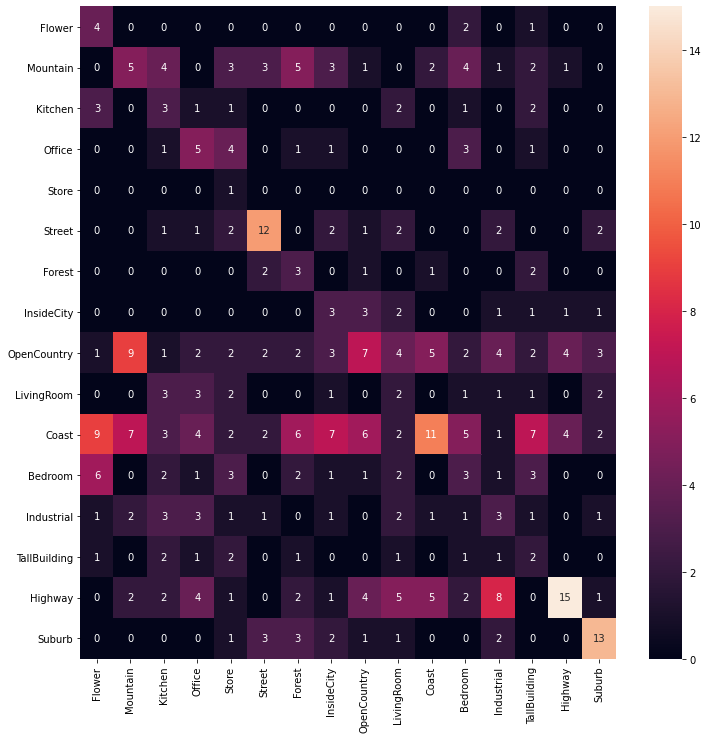

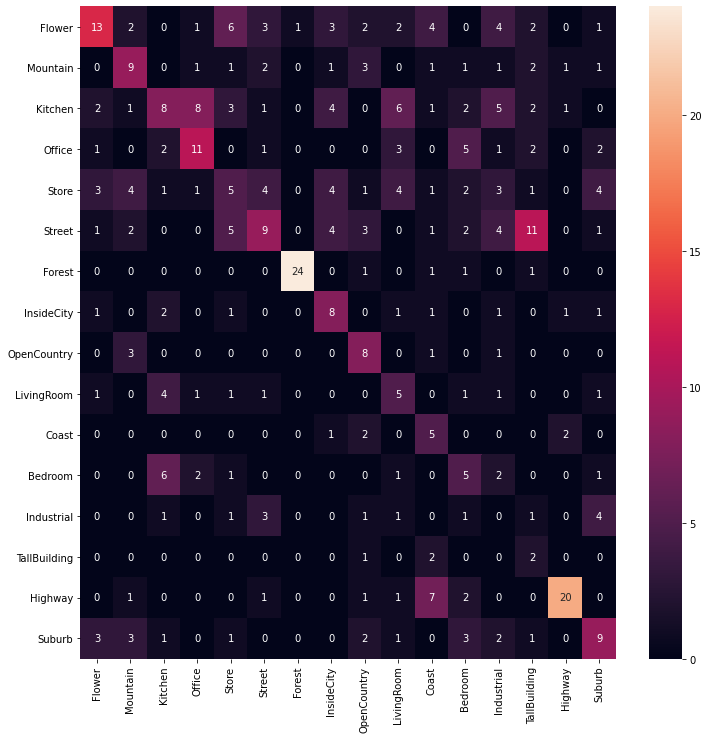

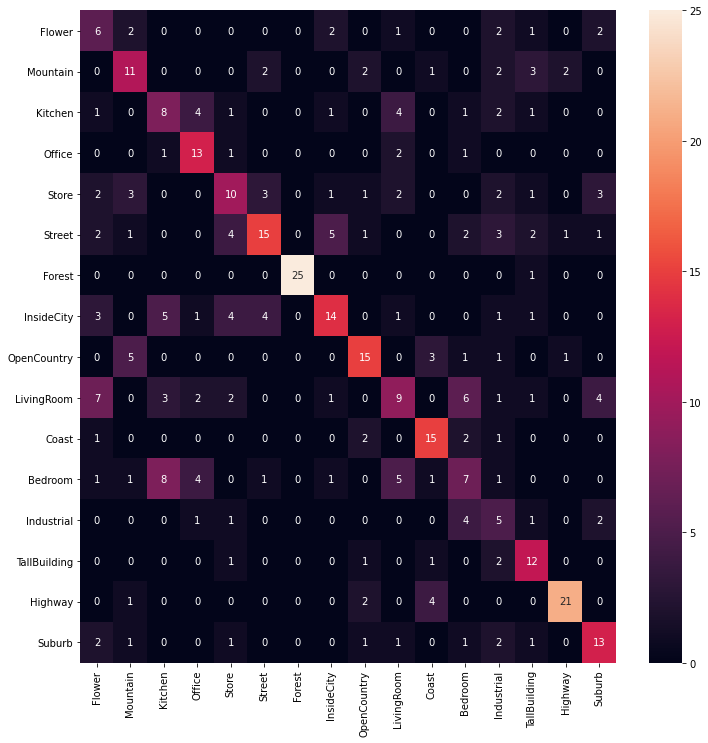

In [86]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import pandas as pd

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    ##########--WRITE YOUR CODE HERE--##########
    df_cm = pd.DataFrame(cm, index = [class_names[i] for i in class_names],
                  columns = [class_names[i] for i in class_names])
    
    
    ##########-------END OF CODE-------##########
    return sns.heatmap(df_cm, annot=True)

#First combination:
# Confusion matrix
cm1 = confusion_matrix(pred1, test_label)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm1, class_names, normalize=True)
plt.show()

# Second combination:
# Confusion matrix
cm2 = confusion_matrix(pred2, test_label)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm2, class_names, normalize=True)
plt.show()

#Third combination:
# Confusion matrix
cm3 = confusion_matrix(pred3, test_label)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm3, class_names, normalize=True)
plt.show()

## Submission guidelines
---
Your need to submit a single zip file to Blackboard described as follow.

Please generate a pdf file that includes a ***google shared link*** (explained in the next paragraph). This pdf file should be named as ***Surname_Givenname_SBUID_hw*\*.pdf** (example: Jordan_Michael_111234567_hw3.pdf for this assignment).

To generate the ***google shared link***, first create a folder named ***Surname_Givenname_SBUID_hw**** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. For instance in this homework:

```
Surname_Givenname_SBUID_hw3
        |---dataset.pkl
        |---CSE527-HW3-fall20.ipynb
        |---Surname_Givenname_SBUID_Pred.txt
```
Note that this folder should be in your Google Drive with your Stony Brook account. 

Then right click this folder, click ***Get shareable link***, in the People textfield, enter the TA's email: ***xiang.li.7@stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **UNCHECK** the Notify people box.

Note that in google colab, we will only grade the version of the code right before the timestamp of the submission made in blackboard. 

To submit to Blackboard, zip ***Surname_Givenname_SBUID_hw*\*.pdf** and ***Surname_Givenname_SBUID_hw**** folder together and name your zip file as ***Surname_Givenname_SBUID_hw*\*.zip**. 

**DO NOT upload dataset.pkl to Blackboard.**

The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw3' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs.


-- DO NOT change the folder structure, please just fill in the blanks. <br>

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.
